In [ ]:
import numpy as np
from pathlib import Path

IN = Path("./portable_mesh.npz")
data = np.load(IN, allow_pickle=False)

V    = data["V"]          # (U, 3) float
F    = data["F"]          # (K, 3) int
xmin = float(data["xmin"])
ymin = float(data["ymin"])

print(V.shape, F.shape, xmin, ymin)
print("done")

In [10]:
import re
import numpy as np
import pandas as pd
from pathlib import Path
from joblib import Parallel, delayed

# -------------------- Config --------------------
FOLDER_FREQ = "7GHz"
f_hz = 7e9
include_tx_indices = [1,2,3,4,6,7,8,10,11,13,15,16,17,18,19]
INPUT_DIR = Path("b_training_propagation_loss") / FOLDER_FREQ
BASE_DIR  = Path("./extracted_regions/train")
BASE_DIR.mkdir(parents=True, exist_ok=True)

R_SPH = 50.0
x0 = float(globals().get("xmin", 0.0))
y0 = float(globals().get("ymin", 0.0))

# -------------------- Pick files --------------------
def tx_filename(freq_prefix, idx): return f"{freq_prefix}_Tx_{idx}.csv"

files, missing = [], []
for idx in include_tx_indices:
    p = INPUT_DIR / tx_filename(FOLDER_FREQ, idx)
    (files if p.exists() else missing).append(p if p.exists() else idx)
if missing: print(f"[WARN] Missing files for indices: {missing}")
files = sorted(files, key=lambda p: int(re.search(r"_Tx_(\d+)\.csv$", p.name).group(1)))

# -------------------- Build TX/RX arrays --------------------
TX_by_txnum, RX_by_txnum = {}, {}
for csv_path in files:
    m = re.search(r"_Tx_(\d+)\.csv$", csv_path.name)
    if not m: continue
    tx_num = int(m.group(1))
    df = pd.read_csv(csv_path)

    tx = df.iloc[0, [0,1,2]].to_numpy(dtype=float)[None,:]
    rx = df.iloc[:, [6,7,8]].to_numpy(dtype=float)

    tx[:,0] -= x0; tx[:,1] -= y0
    rx[:,0] -= x0; rx[:,1] -= y0

    tx_paired = np.repeat(tx, rx.shape[0], axis=0)

    TX_by_txnum[tx_num] = tx_paired
    RX_by_txnum[tx_num] = rx

# -------------------- Sphere helpers --------------------
def dedupe_points(pts, eps=1e-7):
    out = []
    for p in pts:
        if not any(np.linalg.norm(p-q)<eps for q in out):
            out.append(p)
    return out

def order_polygon(poly, a, b, c):
    centroid = poly.mean(axis=0)
    n = np.cross(b-a, c-a)
    n_norm = np.linalg.norm(n)
    if n_norm < 1e-12:
        rel2 = poly[:, :2] - centroid[:2]
        return poly[np.argsort(np.arctan2(rel2[:,1], rel2[:,0]))]
    n /= n_norm
    u = b-a; u /= (np.linalg.norm(u)+1e-15)
    v = np.cross(n, u)
    rel = poly - centroid
    ang = np.arctan2(rel@v, rel@u)
    return poly[np.argsort(ang)]

def clip_triangle_sphere(a, b, c, C, R):
    pts = [a,b,c]
    poly = [p for p in pts if np.linalg.norm(p-C)<=R]
    poly = dedupe_points(poly)
    if len(poly)<3: return None
    return order_polygon(np.array(poly), a, b, c)

def clip_mesh_sphere(C, R):
    polys = []
    for tri in F:
        a,b,c = V[tri[0]], V[tri[1]], V[tri[2]]
        poly = clip_triangle_sphere(a,b,c,C,R)
        if poly is not None: polys.append(poly)
    return polys

# -------------------- Save --------------------
def save_region_npz(path, polys, meta):
    path.parent.mkdir(parents=True, exist_ok=True)
    obj = np.empty(len(polys), dtype=object)
    for i, p in enumerate(polys): obj[i] = p.astype(float)
    np.savez_compressed(path, polys=obj, **meta)

def make_pair_fname(i, tag): return f"pair{i:05d}_{tag}.npz"

# -------------------- Worker --------------------
def process_single_pair(i, Tx, Rx, tx_dir, rx_dir):
    # RX sphere
    p_rx = rx_dir / make_pair_fname(i, "rx_sphere50")
    if p_rx.exists():
        wrote_rx = 0
    else:
        polys_rx = clip_mesh_sphere(Rx, R_SPH)
        save_region_npz(p_rx, polys_rx, dict(region="rx_sphere50", Tx=Tx, Rx=Rx))
        wrote_rx = len(polys_rx)

    # TX sphere (only once)
    p_tx = tx_dir / "tx_sphere50.npz"
    if p_tx.exists():
        wrote_tx = 0
    else:
        polys_tx = clip_mesh_sphere(Tx, R_SPH)
        save_region_npz(p_tx, polys_tx, dict(region="tx_sphere50", Tx=Tx))
        wrote_tx = len(polys_tx)

    return wrote_rx, wrote_tx

# -------------------- Main --------------------
if __name__ == "__main__":
    for tx_num in sorted(TX_by_txnum.keys()):
        rx_dir = BASE_DIR / f"rx_sphere_Tx_{tx_num}"
        tx_dir = BASE_DIR / f"tx_sphere_Tx_{tx_num}"
        rx_dir.mkdir(parents=True, exist_ok=True)
        tx_dir.mkdir(parents=True, exist_ok=True)

        TX_arr = TX_by_txnum[tx_num]
        RX_arr = RX_by_txnum[tx_num]

        N = TX_arr.shape[0]
        to_run = [i for i in range(N) if not (rx_dir / make_pair_fname(i,"rx_sphere50")).exists()]
        print(f"\n=== Tx {tx_num}: {N} RX pairs ===  -> {len(to_run)} to compute, {N-len(to_run)} already exist")
        if (tx_dir / "tx_sphere50.npz").exists(): print("  -> TX sphere already exists")
        else: print("  -> TX sphere will be computed")

        if to_run:
            results = Parallel(n_jobs=-1)(
                delayed(process_single_pair)(i, TX_arr[i], RX_arr[i], tx_dir, rx_dir) for i in to_run
            )
            total = np.array(results).sum(axis=0)
            print(f"  -> Written polys RX:{total[0]}, TX:{total[1]}")
        else:
            print("  -> Nothing new written")



=== Tx 1: 29554 RX pairs ===  -> 0 to compute, 29554 already exist
  -> TX sphere already exists
  -> Nothing new written

=== Tx 2: 23262 RX pairs ===  -> 0 to compute, 23262 already exist
  -> TX sphere already exists
  -> Nothing new written

=== Tx 3: 25100 RX pairs ===  -> 0 to compute, 25100 already exist
  -> TX sphere will be computed
  -> Nothing new written

=== Tx 4: 23783 RX pairs ===  -> 0 to compute, 23783 already exist
  -> TX sphere already exists
  -> Nothing new written

=== Tx 6: 24512 RX pairs ===  -> 0 to compute, 24512 already exist
  -> TX sphere will be computed
  -> Nothing new written

=== Tx 7: 23475 RX pairs ===  -> 0 to compute, 23475 already exist
  -> TX sphere will be computed
  -> Nothing new written

=== Tx 8: 24016 RX pairs ===  -> 0 to compute, 24016 already exist
  -> TX sphere will be computed
  -> Nothing new written

=== Tx 10: 26167 RX pairs ===  -> 0 to compute, 26167 already exist
  -> TX sphere will be computed
  -> Nothing new written

=== 

In [5]:
import re, os
import numpy as np
import pandas as pd
from pathlib import Path
from joblib import Parallel, delayed

# -------------------- Config --------------------
FOLDER_FREQ = "7GHz" #800MHz, 7GHz, 28GHz
f_hz = 7e9  # 800e6, 7e9, , 2.8e10 ...
include_tx_indices = [5,9,12,14,20]  # [] to read all found
INPUT_DIR = Path("c_evaluation_propagation_loss") / FOLDER_FREQ
BASE_DIR  = Path("./extracted_regions/test")  # output root
BASE_DIR.mkdir(parents=True, exist_ok=True)

c0  = 3e8
lam = c0 / float(f_hz)
R_SPH = 50.0


# Optional XY shift from your environment
x0 = float(globals().get("xmin", 0.0))
y0 = float(globals().get("ymin", 0.0))

# -------------------- Pick files --------------------
def tx_filename(freq_prefix, idx): return f"{freq_prefix}_Tx_{idx}.csv"

if include_tx_indices:
    files, missing = [], []
    for idx in include_tx_indices:
        p = INPUT_DIR / tx_filename(FOLDER_FREQ, idx)
        (files if p.exists() else missing).append(p if p.exists() else idx)
    if missing: print(f"[WARN] Missing files for indices: {missing}")
    files = sorted(files, key=lambda p: int(re.search(r"_Tx_(\d+)\.csv$", p.name).group(1)))
else:
    patt = re.compile(r"_Tx_(\d+)\.csv$", re.I)
    files = sorted([p for p in INPUT_DIR.glob(f"{FOLDER_FREQ}_Tx_*.csv") if patt.search(p.name)],
                   key=lambda p: int(patt.search(p.name).group(1)))

print("\nFiles to read:")
for p in files: print("  -", p.name)

# -------------------- Build per-file TX/RX --------------------
TX_train_by_txnum, RX_train_by_txnum, per_file_counts = {}, {}, []
txnum_re = re.compile(r"_Tx_(\d+)\.csv$", re.I)

for csv_path in files:
    m = txnum_re.search(csv_path.name)
    if not m:
        print(f"[SKIP] No Tx index in {csv_path.name}");
        continue
    tx_num = int(m.group(1))

    df = pd.read_csv(csv_path)
    tx = df.iloc[0, [0, 1, 2]].to_numpy(dtype=float)[None, :]  # (1,3)
    rx = df.iloc[:, [6, 7, 8]].to_numpy(dtype=float)        # (N_rx,3)

    # Shift XY to mesh frame
    tx_shift = tx.copy(); rx_shift = rx.copy()
    tx_shift[:, 0] -= x0; tx_shift[:, 1] -= y0
    rx_shift[:, 0] -= x0; rx_shift[:, 1] -= y0

    tx_paired = np.repeat(tx_shift, rx_shift.shape[0], axis=0)  # (N_rx,3)

    TX_train_by_txnum[tx_num] = tx_paired
    RX_train_by_txnum[tx_num] = rx_shift
    per_file_counts.append((csv_path.name, rx_shift.shape[0]))

print("\nPer-file RX counts:")
for name, cnt in per_file_counts:
    print(f"  {name:>25s}  RX: {cnt}")

# (optional) globals for convenience
for tx_num, arr in TX_train_by_txnum.items(): globals()[f"TX_train_list_{tx_num}"] = arr
for tx_num, arr in RX_train_by_txnum.items(): globals()[f"RX_train_list_{tx_num}"] = arr

# -------------------- Geometry helpers --------------------
def sample_face_points(vertices, faces):
    v = vertices
    i0, i1, i2 = faces[:,0], faces[:,1], faces[:,2]
    a, b, c_   = v[i0], v[i1], v[i2]
    centroid   = (a + b + c_) / 3.0
    ab = 0.5*(a + b); bc = 0.5*(b + c_); ca = 0.5*(c_ + a)
    return np.stack([a, b, c_, centroid, ab, bc, ca], axis=1)

def order_polygon_in_triangle_plane(poly, a, b, c):
    centroid = poly.mean(axis=0)
    n = np.cross(b - a, c - a); n_norm = np.linalg.norm(n)
    if n_norm < 1e-12:
        rel2 = poly[:, :2] - centroid[:2]
        return poly[np.argsort(np.arctan2(rel2[:,1], rel2[:,0]))]
    n = n / n_norm
    u = b - a; u = u / (np.linalg.norm(u) + 1e-15)
    v = np.cross(n, u)
    rel = poly - centroid
    ang = np.arctan2(rel @ v, rel @ u)
    return poly[np.argsort(ang)]

def dedupe_points(pts, eps=1e-7):
    out = []
    for p in pts:
        if not any(np.linalg.norm(p - q) < eps for q in out):
            out.append(p)
    return out

# -------------------- Fresnel ellipsoid --------------------
def T_fresnel(Tx, Rx, n):
    D = float(np.linalg.norm(Rx - Tx))
    return D + n * lam / 2.0, D

def f_ellipsoid(p, Tx, Rx, T):
    return np.linalg.norm(p - Tx) + np.linalg.norm(p - Rx) - T

def edge_intersection_ellipsoid(p0, p1, Tx, Rx, T, f0=None, f1=None, tol=1e-6, max_iter=40):
    if f0 is None: f0 = f_ellipsoid(p0, Tx, Rx, T)
    if f1 is None: f1 = f_ellipsoid(p1, Tx, Rx, T)
    if abs(f0) < tol: return p0
    if abs(f1) < tol: return p1
    if (f0 > 0 and f1 > 0) or (f0 < 0 and f1 < 0): return None
    t0, t1 = 0.0, 1.0
    for _ in range(max_iter):
        tm = 0.5*(t0 + t1)
        pm = p0 + tm*(p1 - p0)
        fm = f_ellipsoid(pm, Tx, Rx, T)
        if abs(fm) < tol: return pm
        if (f0 <= 0 and fm <= 0) or (f0 >= 0 and fm >= 0):
            t0, f0 = tm, fm
        else:
            t1, f1 = tm, fm
    return p0 + 0.5*(t0 + t1)*(p1 - p0)

def clip_triangle_to_ellipsoid(a, b, c, Tx, Rx, T):
    pts    = [a, b, c]
    fvals  = [f_ellipsoid(p, Tx, Rx, T) for p in pts]
    poly_pts = [p for p, ok in zip(pts, [fv<=0 for fv in fvals]) if ok]
    for (i,j) in ((0,1),(1,2),(2,0)):
        inter = edge_intersection_ellipsoid(pts[i], pts[j], Tx, Rx, T, fvals[i], fvals[j])
        if inter is not None: poly_pts.append(inter)
    poly_pts = dedupe_points(poly_pts)
    if len(poly_pts) < 3: return None
    return order_polygon_in_triangle_plane(np.array(poly_pts), a, b, c)

def clip_mesh_to_ellipsoid(Tx, Rx, T):
    # NOTE: V and F are now accessed from the global scope
    S  = sample_face_points(V, F)
    d1 = np.linalg.norm(S - Tx[None,None,:], axis=2)
    d2 = np.linalg.norm(S - Rx[None,None,:], axis=2)
    mask   = (d1 + d2) <= (T + 1e-9)
    F_used = F[np.where(mask.any(axis=1))[0]]
    polys = []
    for tri in F_used:
        a, b, c = V[tri[0]], V[tri[1]], V[tri[2]]
        poly = clip_triangle_to_ellipsoid(a, b, c, Tx, Rx, T)
        if poly is not None: polys.append(poly)
    return polys, F_used

# -------------------- Sphere functions REMOVED --------------------
# The functions f_sphere, edge_intersection_sphere, clip_triangle_to_sphere,
# and clip_mesh_to_sphere have been removed as they are no longer needed.

# -------------------- Saving --------------------
def save_region_npz(path, polys, meta):
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    obj_polys = np.empty(len(polys), dtype=object)
    for i, p in enumerate(polys): obj_polys[i] = p.astype(float)
    np.savez_compressed(path, polys=obj_polys, **meta)

# -------------------- Per-pair worker --------------------
def make_pair_fname(idx, tag):
    return f"pair{idx:05d}_{tag}.npz"

def process_single_pair(i, Tx, Rx, f_hz, lam, out_dir):
    """
    Process one TX-RX pair and save 2 .npz region files for Fresnel zones.
    V and F are accessed from the global scope.
    """
    # Targets
    p_f1  = out_dir / make_pair_fname(i, "fresnel1")
    p_f3  = out_dir / make_pair_fname(i, "fresnel3")
    
    # Fresnel thresholds (compute once)
    T1, D  = T_fresnel(Tx, Rx, n=1)
    T3, _  = T_fresnel(Tx, Rx, n=3)

    wrote_f1 = wrote_f3 = 0

    # 1) inside 1st Fresnel
    if not p_f1.exists():
        polys_1, Fused_1 = clip_mesh_to_ellipsoid(Tx, Rx, T1)
        save_region_npz(
            p_f1, polys_1,
            dict(Tx=Tx, Rx=Rx, f_hz=f_hz, lam=lam, D=D, T=T1,
                 region="fresnel1", faces_used=Fused_1)
        )
        wrote_f1 = len(polys_1)

    # 2) inside 3rd Fresnel
    if not p_f3.exists():
        polys_3, Fused_3 = clip_mesh_to_ellipsoid(Tx, Rx, T3)
        save_region_npz(
            p_f3, polys_3,
            dict(Tx=Tx, Rx=Rx, f_hz=f_hz, lam=lam, D=D, T=T3,
                 region="fresnel3", faces_used=Fused_3)
        )
        wrote_f3 = len(polys_3)
    
    # Sphere calculations have been removed.

    return (wrote_f1, wrote_f3)


def process_split_parallel_for_txnum(tx_num, TX_arr, RX_arr, folder_freq, max_pairs=None):
    """
    Saves under: ./extracted_regions/train/{folder_freq}_Tx_{tx_num}/
    V and F are accessed from the global scope.
    """
    assert TX_arr.shape == RX_arr.shape and TX_arr.shape[1] == 3
    if max_pairs is not None:
        TX_arr = TX_arr[:max_pairs]
        RX_arr = RX_arr[:max_pairs]

    out_dir = BASE_DIR / f"{folder_freq}_Tx_{tx_num}"
    out_dir.mkdir(parents=True, exist_ok=True)
    N = TX_arr.shape[0]
    print(f"\n=== {folder_freq}_Tx_{tx_num}: {N} RX pairs ===")

    to_run = []
    for i in range(N):
        # MODIFIED: Check only for the fresnel files.
        targets = [
            out_dir / make_pair_fname(i, "fresnel1"),
            out_dir / make_pair_fname(i, "fresnel3"),
        ]
        if all(p.exists() for p in targets):
            continue
        to_run.append(i)

    print(f"  -> {len(to_run)} pairs will be computed (others already present).")

    if not to_run:
        print(f"[Tx {tx_num}] Nothing to do — all pairs exist.")
        return

    # Call the worker function, note that R_SPH is no longer passed.
    results = Parallel(n_jobs=-1, verbose=10)(
        delayed(process_single_pair)(i, TX_arr[i], RX_arr[i], float(f_hz), lam, out_dir)
        for i in to_run
    )

    if results:
        total = np.array(results).sum(axis=0)
        # MODIFIED: Updated print statement for the new return format.
        print(f"[Tx {tx_num}] Newly written polys — F1:{total[0]}, F3:{total[1]}")
    else:
        print(f"[Tx {tx_num}] Nothing new written.")


# -------------------- Run all selected files --------------------
# Main execution loop
if __name__ == "__main__":
    # Ensure V and F (mesh data) are loaded into the global scope before this runs
    # Example:
    # import trimesh
    # mesh = trimesh.load_mesh('path/to/your/mesh.obj')
    # V, F = mesh.vertices, mesh.faces
    
    for tx_num in sorted(TX_train_by_txnum.keys()):
        process_split_parallel_for_txnum(
            tx_num,
            TX_train_by_txnum[tx_num],
            RX_train_by_txnum[tx_num],
            FOLDER_FREQ
        )


Files to read:
  - 7GHz_Tx_5.csv
  - 7GHz_Tx_9.csv
  - 7GHz_Tx_12.csv
  - 7GHz_Tx_14.csv
  - 7GHz_Tx_20.csv

Per-file RX counts:
              7GHz_Tx_5.csv  RX: 23353
              7GHz_Tx_9.csv  RX: 24363
             7GHz_Tx_12.csv  RX: 24016
             7GHz_Tx_14.csv  RX: 22948
             7GHz_Tx_20.csv  RX: 22243

=== 7GHz_Tx_5: 23353 RX pairs ===
  -> 0 pairs will be computed (others already present).
[Tx 5] Nothing to do — all pairs exist.

=== 7GHz_Tx_9: 24363 RX pairs ===
  -> 0 pairs will be computed (others already present).
[Tx 9] Nothing to do — all pairs exist.

=== 7GHz_Tx_12: 24016 RX pairs ===
  -> 0 pairs will be computed (others already present).
[Tx 12] Nothing to do — all pairs exist.

=== 7GHz_Tx_14: 22948 RX pairs ===
  -> 0 pairs will be computed (others already present).
[Tx 14] Nothing to do — all pairs exist.

=== 7GHz_Tx_20: 22243 RX pairs ===
  -> 0 pairs will be computed (others already present).
[Tx 20] Nothing to do — all pairs exist.


In [14]:
import re, os
import numpy as np
import pandas as pd
from pathlib import Path
from joblib import Parallel, delayed

# -------------------- Config --------------------
FOLDER_FREQ = "800MHz"
f_hz = 800e6
include_tx_indices = [1,2,3,4,6,7,8,10,11,13,15,16,17,18,19]  # [] to read all found, or [4] for specific
INPUT_DIR = Path("b_training_propagation_loss") / FOLDER_FREQ
BASE_DIR  = Path("./extracted_regions/train") 
BASE_DIR.mkdir(parents=True, exist_ok=True)

c0  = 3e8
lam = c0 / float(f_hz)
R_SPH = 50.0

# Optional XY shift
x0 = float(globals().get("xmin", 0.0))
y0 = float(globals().get("ymin", 0.0))

# -------------------- Pick files --------------------
def tx_filename(freq_prefix, idx): return f"{freq_prefix}_Tx_{idx}.csv"

if include_tx_indices:
    files, missing = [], []
    for idx in include_tx_indices:
        p = INPUT_DIR / tx_filename(FOLDER_FREQ, idx)
        (files if p.exists() else missing).append(p if p.exists() else idx)
    if missing: print(f"[WARN] Missing files for indices: {missing}")
    files = sorted(files, key=lambda p: int(re.search(r"_Tx_(\d+)\.csv$", p.name).group(1)))
else:
    patt = re.compile(r"_Tx_(\d+)\.csv$", re.I)
    files = sorted([p for p in INPUT_DIR.glob(f"{FOLDER_FREQ}_Tx_*.csv") if patt.search(p.name)],
                   key=lambda p: int(patt.search(p.name).group(1)))

print("\nFiles to read:")
for p in files: print("  -", p.name)

# -------------------- Build per-file TX/RX --------------------
TX_train_by_txnum, RX_train_by_txnum, per_file_counts = {}, {}, []
txnum_re = re.compile(r"_Tx_(\d+)\.csv$", re.I)

for csv_path in files:
    m = txnum_re.search(csv_path.name)
    if not m:
        print(f"[SKIP] No Tx index in {csv_path.name}");
        continue
    tx_num = int(m.group(1))

    df = pd.read_csv(csv_path)
    tx = df.iloc[0, [0, 1, 2]].to_numpy(dtype=float)[None, :]  
    rx = df.iloc[:, [6, 7, 8]].to_numpy(dtype=float)       

    # Shift XY to mesh frame
    tx_shift = tx.copy(); rx_shift = rx.copy()
    tx_shift[:, 0] -= x0; tx_shift[:, 1] -= y0
    rx_shift[:, 0] -= x0; rx_shift[:, 1] -= y0

    tx_paired = np.repeat(tx_shift, rx_shift.shape[0], axis=0) 

    TX_train_by_txnum[tx_num] = tx_paired
    RX_train_by_txnum[tx_num] = rx_shift
    per_file_counts.append((csv_path.name, rx_shift.shape[0]))

print("\nPer-file RX counts:")
for name, cnt in per_file_counts:
    print(f"  {name:>25s}  RX: {cnt}")

# -------------------- Geometry helpers --------------------
def sample_face_points(vertices, faces):
    v = vertices
    i0, i1, i2 = faces[:,0], faces[:,1], faces[:,2]
    a, b, c_   = v[i0], v[i1], v[i2]
    centroid   = (a + b + c_) / 3.0
    ab = 0.5*(a + b); bc = 0.5*(b + c_); ca = 0.5*(c_ + a)
    return np.stack([a, b, c_, centroid, ab, bc, ca], axis=1)

def order_polygon_in_triangle_plane(poly, a, b, c):
    centroid = poly.mean(axis=0)
    n = np.cross(b - a, c - a); n_norm = np.linalg.norm(n)
    if n_norm < 1e-12:
        rel2 = poly[:, :2] - centroid[:2]
        return poly[np.argsort(np.arctan2(rel2[:,1], rel2[:,0]))]
    n = n / n_norm
    u = b - a; u = u / (np.linalg.norm(u) + 1e-15)
    v = np.cross(n, u)
    rel = poly - centroid
    ang = np.arctan2(rel @ v, rel @ u)
    return poly[np.argsort(ang)]

def dedupe_points(pts, eps=1e-7):
    out = []
    for p in pts:
        if not any(np.linalg.norm(p - q) < eps for q in out):
            out.append(p)
    return out

# -------------------- Sphere Logic --------------------
def f_sphere(p, C, R): return np.linalg.norm(p - C) - R

def edge_intersection_sphere(p0, p1, C, R, f0=None, f1=None, tol=1e-6, max_iter=40):
    if f0 is None: f0 = f_sphere(p0, C, R)
    if f1 is None: f1 = f_sphere(p1, C, R)
    if abs(f0) < tol: return p0
    if abs(f1) < tol: return p1
    if (f0 > 0 and f1 > 0) or (f0 < 0 and f1 < 0): return None
    t0, t1 = 0.0, 1.0
    for _ in range(max_iter):
        tm = 0.5*(t0 + t1)
        pm = p0 + tm*(p1 - p0)
        fm = f_sphere(pm, C, R)
        if abs(fm) < tol: return pm
        if (f0 <= 0 and fm <= 0) or (f0 >= 0 and fm >= 0):
            t0, f0 = tm, fm
        else:
            t1, f1 = tm, fm
    return p0 + 0.5*(t0 + t1)*(p1 - p0)

def clip_triangle_to_sphere(a, b, c, C, R):
    pts    = [a, b, c]
    poly_pts = [p for p in pts if f_sphere(p, C, R) <= 0.0]
    for (i,j) in ((0,1),(1,2),(2,0)):
        inter = edge_intersection_sphere(pts[i], pts[j], C, R)
        if inter is not None: poly_pts.append(inter)
    poly_pts = dedupe_points(poly_pts)
    if len(poly_pts) < 3: return None
    return order_polygon_in_triangle_plane(np.array(poly_pts), a, b, c)

def clip_mesh_to_sphere(C, R):
    # NOTE: V and F must be available globally!
    S  = sample_face_points(V, F)
    dC = np.linalg.norm(S - C[None,None,:], axis=2)
    mask   = (dC <= (R + 1e-9))
    F_used = F[np.where(mask.any(axis=1))[0]]
    polys = []
    for tri in F_used:
        a, b, c = V[tri[0]], V[tri[1]], V[tri[2]]
        poly = clip_triangle_to_sphere(a, b, c, C, R)
        if poly is not None: polys.append(poly)
    return polys, F_used

def save_region_npz(path, polys, meta):
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    obj_polys = np.empty(len(polys), dtype=object)
    for i, p in enumerate(polys): obj_polys[i] = p.astype(float)
    np.savez_compressed(path, polys=obj_polys, **meta)

# -------------------- Per-pair worker --------------------
def make_pair_fname(idx, tag):
    return f"pair{idx:05d}_{tag}.npz"

def process_single_pair(i, Tx, Rx, f_hz, lam, R_SPH, dir_tx, dir_rx):
    """
    Saves:
      - Rx sphere -> dir_rx (ALWAYS)
      - Tx sphere -> dir_tx (ONLY if i == 0)
    """
    # 1. Define paths
    p_tx = dir_tx / make_pair_fname(i, "tx_sphere50")
    p_rx = dir_rx / make_pair_fname(i, "rx_sphere50")

    D = float(np.linalg.norm(Rx - Tx))
    wrote_tx = 0
    wrote_rx = 0

    # 2. Tx Sphere: ONLY index 0
    if i == 0:
        if not p_tx.exists():
            polys_tx, Fused_tx = clip_mesh_to_sphere(C=Tx, R=R_SPH)
            save_region_npz(
                p_tx, polys_tx,
                dict(Tx=Tx, Rx=Rx, f_hz=f_hz, lam=lam, D=D, R=R_SPH,
                     region="tx_sphere50", faces_used=Fused_tx)
            )
            wrote_tx = len(polys_tx)

    # 3. Rx Sphere: ALL indices
    if not p_rx.exists():
        polys_rx, Fused_rx = clip_mesh_to_sphere(C=Rx, R=R_SPH)
        save_region_npz(
            p_rx, polys_rx,
            dict(Tx=Tx, Rx=Rx, f_hz=f_hz, lam=lam, D=D, R=R_SPH,
                 region="rx_sphere50", faces_used=Fused_rx)
        )
        wrote_rx = len(polys_rx)

    return (wrote_tx, wrote_rx)


def process_split_parallel_for_txnum(tx_num, TX_arr, RX_arr, folder_freq, max_pairs=None):
    """
    Creates two folders:
      1. ./extracted_regions/train/tx_sphere_Tx_{tx_num} (1 file)
      2. ./extracted_regions/train/rx_sphere_Tx_{tx_num} (N files)
    """
    assert TX_arr.shape == RX_arr.shape and TX_arr.shape[1] == 3
    if max_pairs is not None:
        TX_arr = TX_arr[:max_pairs]
        RX_arr = RX_arr[:max_pairs]

    # Distinct output directories
    dir_tx = BASE_DIR / f"tx_sphere_Tx_{tx_num}"
    dir_rx = BASE_DIR / f"rx_sphere_Tx_{tx_num}"
    dir_tx.mkdir(parents=True, exist_ok=True)
    dir_rx.mkdir(parents=True, exist_ok=True)

    N = TX_arr.shape[0]
    print(f"\n=== {folder_freq} | Tx {tx_num}: {N} RX pairs ===")

    to_run = []
    for i in range(N):
        # Index 0: Check if Tx file exists OR Rx file exists
        if i == 0:
            if not (dir_tx / make_pair_fname(i, "tx_sphere50")).exists() or \
               not (dir_rx / make_pair_fname(i, "rx_sphere50")).exists():
                to_run.append(i)
        # Index > 0: Check if Rx file exists
        else:
            if not (dir_rx / make_pair_fname(i, "rx_sphere50")).exists():
                to_run.append(i)

    print(f"  -> {len(to_run)} pairs will be computed.")

    if not to_run:
        print(f"[Tx {tx_num}] All requested files exist.")
        return

    results = Parallel(n_jobs=-1, verbose=10)(
        delayed(process_single_pair)(i, TX_arr[i], RX_arr[i], float(f_hz), lam, R_SPH, dir_tx, dir_rx)
        for i in to_run
    )

    if results:
        total = np.array(results).sum(axis=0)
        print(f"[Tx {tx_num}] Written — TX50: {total[0]} (only expected 1 max), RX50: {total[1]}")
    else:
        print(f"[Tx {tx_num}] Nothing new written.")


# -------------------- Run --------------------
if __name__ == "__main__":
    # Ensure V (vertices) and F (faces) are loaded here!
    # V = ...
    # F = ...
    
    for tx_num in sorted(TX_train_by_txnum.keys()):
        process_split_parallel_for_txnum(
            tx_num,
            TX_train_by_txnum[tx_num],
            RX_train_by_txnum[tx_num],
            FOLDER_FREQ
        )


Files to read:
  - 800MHz_Tx_1.csv
  - 800MHz_Tx_2.csv
  - 800MHz_Tx_3.csv
  - 800MHz_Tx_4.csv
  - 800MHz_Tx_6.csv
  - 800MHz_Tx_7.csv
  - 800MHz_Tx_8.csv
  - 800MHz_Tx_10.csv
  - 800MHz_Tx_11.csv
  - 800MHz_Tx_13.csv
  - 800MHz_Tx_15.csv
  - 800MHz_Tx_16.csv
  - 800MHz_Tx_17.csv
  - 800MHz_Tx_18.csv
  - 800MHz_Tx_19.csv

Per-file RX counts:
            800MHz_Tx_1.csv  RX: 29554
            800MHz_Tx_2.csv  RX: 23263
            800MHz_Tx_3.csv  RX: 25113
            800MHz_Tx_4.csv  RX: 23831
            800MHz_Tx_6.csv  RX: 24526
            800MHz_Tx_7.csv  RX: 23499
            800MHz_Tx_8.csv  RX: 24018
           800MHz_Tx_10.csv  RX: 26169
           800MHz_Tx_11.csv  RX: 25272
           800MHz_Tx_13.csv  RX: 24160
           800MHz_Tx_15.csv  RX: 22350
           800MHz_Tx_16.csv  RX: 22246
           800MHz_Tx_17.csv  RX: 24732
           800MHz_Tx_18.csv  RX: 26406
           800MHz_Tx_19.csv  RX: 21289

=== 800MHz | Tx 1: 29554 RX pairs ===
  -> 1 pairs will be computed.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s


[Tx 1] Written — TX50: 1248 (only expected 1 max), RX50: 0

=== 800MHz | Tx 2: 23263 RX pairs ===
  -> 1 pairs will be computed.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s


[Tx 2] Written — TX50: 176 (only expected 1 max), RX50: 0

=== 800MHz | Tx 3: 25113 RX pairs ===
  -> 25100 pairs will be computed.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

[Tx 3] Written — TX50: 0 (only expected 1 max), RX50: 14820474

=== 800MHz | Tx 4: 23831 RX pairs ===
  -> 0 pairs will be computed.
[Tx 4] All requested files exist.

=== 800MHz | Tx 6: 24526 RX pairs ===
  -> 0 pairs will be computed.
[Tx 6] All requested files exist.

=== 800MHz | Tx 7: 23499 RX pairs ===
  -> 0 pairs will be computed.
[Tx 7] All requested files exist.

=== 800MHz | Tx 8: 24018 RX pairs ===
  -> 0 pairs will be computed.
[Tx 8] All requested files exist.

=== 800MHz | Tx 10: 26169 RX pairs ===
  -> 0 pairs will be computed.
[Tx 10] All requested files exist.

=== 800MHz | Tx 11: 25272 RX pairs ===
  -> 0 pairs will be computed.
[Tx 11] All requested files exist.

=== 800MHz | Tx 13: 24160 RX pairs ===
  -> 1 pairs will be computed.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s


[Tx 13] Written — TX50: 104 (only expected 1 max), RX50: 0

=== 800MHz | Tx 15: 22350 RX pairs ===
  -> 0 pairs will be computed.
[Tx 15] All requested files exist.

=== 800MHz | Tx 16: 22246 RX pairs ===
  -> 0 pairs will be computed.
[Tx 16] All requested files exist.

=== 800MHz | Tx 17: 24732 RX pairs ===
  -> 0 pairs will be computed.
[Tx 17] All requested files exist.

=== 800MHz | Tx 18: 26406 RX pairs ===
  -> 0 pairs will be computed.
[Tx 18] All requested files exist.

=== 800MHz | Tx 19: 21289 RX pairs ===
  -> 0 pairs will be computed.
[Tx 19] All requested files exist.


In [15]:
import re, os
import numpy as np
import pandas as pd
from pathlib import Path
from joblib import Parallel, delayed

# -------------------- Config --------------------
FOLDER_FREQ = "800MHz"
f_hz = 800e6
include_tx_indices = [5,9,12,14,20]  # [] to read all found, or [4] for specific
INPUT_DIR = Path("c_evaluation_propagation_loss") / FOLDER_FREQ
BASE_DIR  = Path("./extracted_regions/test") 
BASE_DIR.mkdir(parents=True, exist_ok=True)

c0  = 3e8
lam = c0 / float(f_hz)
R_SPH = 50.0

# Optional XY shift
x0 = float(globals().get("xmin", 0.0))
y0 = float(globals().get("ymin", 0.0))

# -------------------- Pick files --------------------
def tx_filename(freq_prefix, idx): return f"{freq_prefix}_Tx_{idx}.csv"

if include_tx_indices:
    files, missing = [], []
    for idx in include_tx_indices:
        p = INPUT_DIR / tx_filename(FOLDER_FREQ, idx)
        (files if p.exists() else missing).append(p if p.exists() else idx)
    if missing: print(f"[WARN] Missing files for indices: {missing}")
    files = sorted(files, key=lambda p: int(re.search(r"_Tx_(\d+)\.csv$", p.name).group(1)))
else:
    patt = re.compile(r"_Tx_(\d+)\.csv$", re.I)
    files = sorted([p for p in INPUT_DIR.glob(f"{FOLDER_FREQ}_Tx_*.csv") if patt.search(p.name)],
                   key=lambda p: int(patt.search(p.name).group(1)))

print("\nFiles to read:")
for p in files: print("  -", p.name)

# -------------------- Build per-file TX/RX --------------------
TX_train_by_txnum, RX_train_by_txnum, per_file_counts = {}, {}, []
txnum_re = re.compile(r"_Tx_(\d+)\.csv$", re.I)

for csv_path in files:
    m = txnum_re.search(csv_path.name)
    if not m:
        print(f"[SKIP] No Tx index in {csv_path.name}");
        continue
    tx_num = int(m.group(1))

    df = pd.read_csv(csv_path)
    tx = df.iloc[0, [0, 1, 2]].to_numpy(dtype=float)[None, :]  
    rx = df.iloc[:, [6, 7, 8]].to_numpy(dtype=float)       

    # Shift XY to mesh frame
    tx_shift = tx.copy(); rx_shift = rx.copy()
    tx_shift[:, 0] -= x0; tx_shift[:, 1] -= y0
    rx_shift[:, 0] -= x0; rx_shift[:, 1] -= y0

    tx_paired = np.repeat(tx_shift, rx_shift.shape[0], axis=0) 

    TX_train_by_txnum[tx_num] = tx_paired
    RX_train_by_txnum[tx_num] = rx_shift
    per_file_counts.append((csv_path.name, rx_shift.shape[0]))

print("\nPer-file RX counts:")
for name, cnt in per_file_counts:
    print(f"  {name:>25s}  RX: {cnt}")

# -------------------- Geometry helpers --------------------
def sample_face_points(vertices, faces):
    v = vertices
    i0, i1, i2 = faces[:,0], faces[:,1], faces[:,2]
    a, b, c_   = v[i0], v[i1], v[i2]
    centroid   = (a + b + c_) / 3.0
    ab = 0.5*(a + b); bc = 0.5*(b + c_); ca = 0.5*(c_ + a)
    return np.stack([a, b, c_, centroid, ab, bc, ca], axis=1)

def order_polygon_in_triangle_plane(poly, a, b, c):
    centroid = poly.mean(axis=0)
    n = np.cross(b - a, c - a); n_norm = np.linalg.norm(n)
    if n_norm < 1e-12:
        rel2 = poly[:, :2] - centroid[:2]
        return poly[np.argsort(np.arctan2(rel2[:,1], rel2[:,0]))]
    n = n / n_norm
    u = b - a; u = u / (np.linalg.norm(u) + 1e-15)
    v = np.cross(n, u)
    rel = poly - centroid
    ang = np.arctan2(rel @ v, rel @ u)
    return poly[np.argsort(ang)]

def dedupe_points(pts, eps=1e-7):
    out = []
    for p in pts:
        if not any(np.linalg.norm(p - q) < eps for q in out):
            out.append(p)
    return out

# -------------------- Sphere Logic --------------------
def f_sphere(p, C, R): return np.linalg.norm(p - C) - R

def edge_intersection_sphere(p0, p1, C, R, f0=None, f1=None, tol=1e-6, max_iter=40):
    if f0 is None: f0 = f_sphere(p0, C, R)
    if f1 is None: f1 = f_sphere(p1, C, R)
    if abs(f0) < tol: return p0
    if abs(f1) < tol: return p1
    if (f0 > 0 and f1 > 0) or (f0 < 0 and f1 < 0): return None
    t0, t1 = 0.0, 1.0
    for _ in range(max_iter):
        tm = 0.5*(t0 + t1)
        pm = p0 + tm*(p1 - p0)
        fm = f_sphere(pm, C, R)
        if abs(fm) < tol: return pm
        if (f0 <= 0 and fm <= 0) or (f0 >= 0 and fm >= 0):
            t0, f0 = tm, fm
        else:
            t1, f1 = tm, fm
    return p0 + 0.5*(t0 + t1)*(p1 - p0)

def clip_triangle_to_sphere(a, b, c, C, R):
    pts    = [a, b, c]
    poly_pts = [p for p in pts if f_sphere(p, C, R) <= 0.0]
    for (i,j) in ((0,1),(1,2),(2,0)):
        inter = edge_intersection_sphere(pts[i], pts[j], C, R)
        if inter is not None: poly_pts.append(inter)
    poly_pts = dedupe_points(poly_pts)
    if len(poly_pts) < 3: return None
    return order_polygon_in_triangle_plane(np.array(poly_pts), a, b, c)

def clip_mesh_to_sphere(C, R):
    # NOTE: V and F must be available globally!
    S  = sample_face_points(V, F)
    dC = np.linalg.norm(S - C[None,None,:], axis=2)
    mask   = (dC <= (R + 1e-9))
    F_used = F[np.where(mask.any(axis=1))[0]]
    polys = []
    for tri in F_used:
        a, b, c = V[tri[0]], V[tri[1]], V[tri[2]]
        poly = clip_triangle_to_sphere(a, b, c, C, R)
        if poly is not None: polys.append(poly)
    return polys, F_used

def save_region_npz(path, polys, meta):
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    obj_polys = np.empty(len(polys), dtype=object)
    for i, p in enumerate(polys): obj_polys[i] = p.astype(float)
    np.savez_compressed(path, polys=obj_polys, **meta)

# -------------------- Per-pair worker --------------------
def make_pair_fname(idx, tag):
    return f"pair{idx:05d}_{tag}.npz"

def process_single_pair(i, Tx, Rx, f_hz, lam, R_SPH, dir_tx, dir_rx):
    """
    Saves:
      - Rx sphere -> dir_rx (ALWAYS)
      - Tx sphere -> dir_tx (ONLY if i == 0)
    """
    # 1. Define paths
    p_tx = dir_tx / make_pair_fname(i, "tx_sphere50")
    p_rx = dir_rx / make_pair_fname(i, "rx_sphere50")

    D = float(np.linalg.norm(Rx - Tx))
    wrote_tx = 0
    wrote_rx = 0

    # 2. Tx Sphere: ONLY index 0
    if i == 0:
        if not p_tx.exists():
            polys_tx, Fused_tx = clip_mesh_to_sphere(C=Tx, R=R_SPH)
            save_region_npz(
                p_tx, polys_tx,
                dict(Tx=Tx, Rx=Rx, f_hz=f_hz, lam=lam, D=D, R=R_SPH,
                     region="tx_sphere50", faces_used=Fused_tx)
            )
            wrote_tx = len(polys_tx)

    # 3. Rx Sphere: ALL indices
    if not p_rx.exists():
        polys_rx, Fused_rx = clip_mesh_to_sphere(C=Rx, R=R_SPH)
        save_region_npz(
            p_rx, polys_rx,
            dict(Tx=Tx, Rx=Rx, f_hz=f_hz, lam=lam, D=D, R=R_SPH,
                 region="rx_sphere50", faces_used=Fused_rx)
        )
        wrote_rx = len(polys_rx)

    return (wrote_tx, wrote_rx)


def process_split_parallel_for_txnum(tx_num, TX_arr, RX_arr, folder_freq, max_pairs=None):
    """
    Creates two folders:
      1. ./extracted_regions/train/tx_sphere_Tx_{tx_num} (1 file)
      2. ./extracted_regions/train/rx_sphere_Tx_{tx_num} (N files)
    """
    assert TX_arr.shape == RX_arr.shape and TX_arr.shape[1] == 3
    if max_pairs is not None:
        TX_arr = TX_arr[:max_pairs]
        RX_arr = RX_arr[:max_pairs]

    # Distinct output directories
    dir_tx = BASE_DIR / f"tx_sphere_Tx_{tx_num}"
    dir_rx = BASE_DIR / f"rx_sphere_Tx_{tx_num}"
    dir_tx.mkdir(parents=True, exist_ok=True)
    dir_rx.mkdir(parents=True, exist_ok=True)

    N = TX_arr.shape[0]
    print(f"\n=== {folder_freq} | Tx {tx_num}: {N} RX pairs ===")

    to_run = []
    for i in range(N):
        # Index 0: Check if Tx file exists OR Rx file exists
        if i == 0:
            if not (dir_tx / make_pair_fname(i, "tx_sphere50")).exists() or \
               not (dir_rx / make_pair_fname(i, "rx_sphere50")).exists():
                to_run.append(i)
        # Index > 0: Check if Rx file exists
        else:
            if not (dir_rx / make_pair_fname(i, "rx_sphere50")).exists():
                to_run.append(i)

    print(f"  -> {len(to_run)} pairs will be computed.")

    if not to_run:
        print(f"[Tx {tx_num}] All requested files exist.")
        return

    results = Parallel(n_jobs=-1, verbose=10)(
        delayed(process_single_pair)(i, TX_arr[i], RX_arr[i], float(f_hz), lam, R_SPH, dir_tx, dir_rx)
        for i in to_run
    )

    if results:
        total = np.array(results).sum(axis=0)
        print(f"[Tx {tx_num}] Written — TX50: {total[0]} (only expected 1 max), RX50: {total[1]}")
    else:
        print(f"[Tx {tx_num}] Nothing new written.")


# -------------------- Run --------------------
if __name__ == "__main__":
    # Ensure V (vertices) and F (faces) are loaded here!
    # V = ...
    # F = ...
    
    for tx_num in sorted(TX_train_by_txnum.keys()):
        process_split_parallel_for_txnum(
            tx_num,
            TX_train_by_txnum[tx_num],
            RX_train_by_txnum[tx_num],
            FOLDER_FREQ
        )


Files to read:
  - 800MHz_Tx_5.csv
  - 800MHz_Tx_9.csv
  - 800MHz_Tx_12.csv
  - 800MHz_Tx_14.csv
  - 800MHz_Tx_20.csv

Per-file RX counts:
            800MHz_Tx_5.csv  RX: 23358
            800MHz_Tx_9.csv  RX: 24369
           800MHz_Tx_12.csv  RX: 24022
           800MHz_Tx_14.csv  RX: 22961
           800MHz_Tx_20.csv  RX: 22243

=== 800MHz | Tx 5: 23358 RX pairs ===
  -> 0 pairs will be computed.
[Tx 5] All requested files exist.

=== 800MHz | Tx 9: 24369 RX pairs ===
  -> 0 pairs will be computed.
[Tx 9] All requested files exist.

=== 800MHz | Tx 12: 24022 RX pairs ===
  -> 0 pairs will be computed.
[Tx 12] All requested files exist.

=== 800MHz | Tx 14: 22961 RX pairs ===
  -> 0 pairs will be computed.
[Tx 14] All requested files exist.

=== 800MHz | Tx 20: 22243 RX pairs ===
  -> 0 pairs will be computed.
[Tx 20] All requested files exist.



Loading from:
Fresnel: /home/mkrishne/PL_competition/extracted_regions/train/7GHz_Tx_1
RX: /home/mkrishne/PL_competition/extracted_regions/train/rx_sphere_Tx_1
TX: /home/mkrishne/PL_competition/extracted_regions/train/tx_sphere_Tx_1


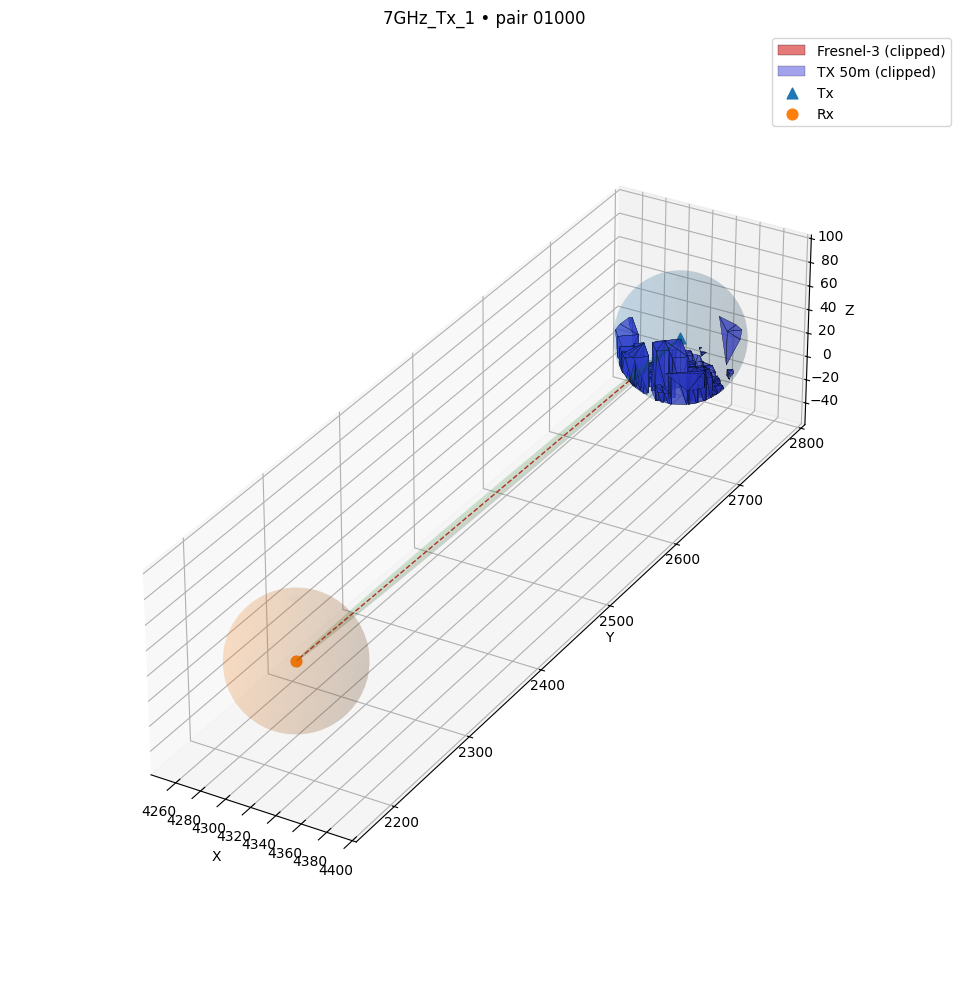

In [20]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import re

# ------------------------------------------------------------------
# Point this at:
#   extracted_regions/train/7GHz_Tx_1/
# ------------------------------------------------------------------
BASE_DIR_FOR_PLOT = Path("/home/mkrishne/PL_competition/extracted_regions/train/7GHz_Tx_1/")
PAIR_IDX_FOR_PLOT = 1000


# =========================
# I/O HELPERS
# =========================
def _npz_path(base_dir: Path, pair_idx: int, tag: str) -> Path:
    return base_dir / f"pair{pair_idx:05d}_{tag}.npz"


def _load_region(base_dir: Path, pair_idx: int, tag: str):
    path = _npz_path(base_dir, pair_idx, tag)

    if not path.exists():
        print(f"[WARN] Missing file: {path}")
        return [], None

    dat = np.load(path, allow_pickle=True)

    polys = []
    for p in dat["polys"]:
        if p is not None and len(p) >= 3:
            polys.append(p.astype(float))

    meta = {k: dat[k] for k in dat.files if k != "polys"}

    if "Tx" in meta:
        meta["Tx"] = np.array(meta["Tx"], dtype=float).reshape(-1)
    if "Rx" in meta:
        meta["Rx"] = np.array(meta["Rx"], dtype=float).reshape(-1)

    return polys, meta


# =========================
# SURFACES
# =========================
def _sphere_surface(C, R, n_theta=36, n_phi=60):
    theta = np.linspace(0.0, np.pi, n_theta)
    phi   = np.linspace(0.0, 2.0*np.pi, n_phi)
    T, P  = np.meshgrid(theta, phi)

    X = C[0] + R*np.sin(T)*np.cos(P)
    Y = C[1] + R*np.sin(T)*np.sin(P)
    Z = C[2] + R*np.cos(T)
    return X, Y, Z


def _fresnel_ellipsoid_surface(T, Tx, Rx, n_theta=48, n_phi=80):
    D = float(np.linalg.norm(Rx - Tx))

    a = T / 2.0
    c = D / 2.0
    b = np.sqrt(max(a*a - c*c, 0.0))

    center = 0.5*(Tx + Rx)

    theta = np.linspace(0.0, np.pi, n_theta)
    phi   = np.linspace(0.0, 2.0*np.pi, n_phi)
    Tm, Pm = np.meshgrid(theta, phi)

    Xloc = a * np.cos(Tm)
    Yloc = b * np.sin(Tm) * np.cos(Pm)
    Zloc = b * np.sin(Tm) * np.sin(Pm)

    u = (Rx - Tx) / (D + 1e-15)

    tmp = np.array([0.0,0.0,1.0]) if abs(np.dot(u,[0,0,1])) < 0.9 else np.array([0.0,1.0,0.0])
    v = np.cross(u, tmp)
    v /= (np.linalg.norm(v) + 1e-15)
    w = np.cross(u, v)

    X = center[0] + Xloc*u[0] + Yloc*v[0] + Zloc*w[0]
    Y = center[1] + Xloc*u[1] + Yloc*v[1] + Zloc*w[1]
    Z = center[2] + Xloc*u[2] + Yloc*v[2] + Zloc*w[2]

    return X, Y, Z


# =========================
# MAIN PLOTTING
# =========================
def plot_folder(base_dir: Path, pair_idx: int):

    # ---------------------------------------------
    # Extract Tx number
    # ---------------------------------------------
    m = re.search(r"_Tx_(\d+)", base_dir.name)
    if not m:
        raise ValueError("Could not extract Tx number from folder name.")

    tx_num = int(m.group(1))

    root_dir = base_dir.parent

    fresnel_dir = base_dir
    rx_dir = root_dir / f"rx_sphere_Tx_{tx_num}"
    tx_dir = root_dir / f"tx_sphere_Tx_{tx_num}"

    print("\nLoading from:")
    print("Fresnel:", fresnel_dir)
    print("RX:", rx_dir)
    print("TX:", tx_dir)

    # ---------------------------------------------
    # Load data
    # ---------------------------------------------
    polys_F1, meta_F1 = _load_region(fresnel_dir, pair_idx, "fresnel3")
    polys_RX, meta_RX = _load_region(rx_dir, pair_idx, "rx_sphere50")

    tx_file = tx_dir / "pair00000_tx_sphere50.npz"
    if not tx_file.exists():
        raise FileNotFoundError(f"Missing TX sphere file: {tx_file}")

    dat_tx = np.load(tx_file, allow_pickle=True)
    polys_TX = [p.astype(float) for p in dat_tx["polys"] if p is not None and len(p) >= 3]
    meta_TX = {k: dat_tx[k] for k in dat_tx.files if k != "polys"}

    meta_TX["Tx"] = np.array(meta_TX["Tx"], dtype=float).reshape(-1)

    if not polys_F1 and not polys_TX and not polys_RX:
        print("Nothing to plot.")
        return

    Tx = meta_F1["Tx"]
    Rx = meta_F1["Rx"]
    T  = float(meta_F1["T"])
    R  = float(meta_TX["R"])

    # ---------------------------------------------
    # Surfaces
    # ---------------------------------------------
    Xs_tx, Ys_tx, Zs_tx = _sphere_surface(Tx, R)
    Xs_rx, Ys_rx, Zs_rx = _sphere_surface(Rx, R)
    Xe, Ye, Ze = _fresnel_ellipsoid_surface(T, Tx, Rx)

    # ---------------------------------------------
    # Aspect ratio
    # ---------------------------------------------
    all_sets = []

    for L in (polys_F1, polys_TX, polys_RX):
        if L:
            all_sets.append(np.concatenate(L, axis=0))

    all_sets.extend([
        Tx[None,:], Rx[None,:],
        np.c_[Xs_tx.ravel(), Ys_tx.ravel(), Zs_tx.ravel()],
        np.c_[Xs_rx.ravel(), Ys_rx.ravel(), Zs_rx.ravel()],
        np.c_[Xe.ravel(),    Ye.ravel(),    Ze.ravel()]
    ])

    all_pts = np.concatenate(all_sets, axis=0)
    mins = all_pts.min(axis=0)
    maxs = all_pts.max(axis=0)
    span = maxs - mins
    span[span == 0] = 1.0

    # ---------------------------------------------
    # PLOT
    # ---------------------------------------------
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111, projection='3d')

    if polys_F1:
        ax.add_collection3d(Poly3DCollection(
            polys_F1, facecolor=(0.85,0.2,0.2,0.65),
            edgecolor='k', linewidths=0.2,
            label='Fresnel-3 (clipped)'
        ))

    if polys_TX:
        ax.add_collection3d(Poly3DCollection(
            polys_TX, facecolor=(0.2,0.2,0.85,0.45),
            edgecolor='k', linewidths=0.15,
            label='TX 50m (clipped)'
        ))

    if polys_RX:
        ax.add_collection3d(Poly3DCollection(
            polys_RX, facecolor=(0.85,0.65,0.2,0.45),
            edgecolor='k', linewidths=0.15,
            label='RX 50m (clipped)'
        ))

    ax.plot_surface(Xs_tx, Ys_tx, Zs_tx, alpha=0.12)
    ax.plot_surface(Xs_rx, Ys_rx, Zs_rx, alpha=0.12)
    ax.plot_surface(Xe, Ye, Ze, alpha=0.10)

    ax.scatter(*Tx, s=60, marker='^', label='Tx')
    ax.scatter(*Rx, s=60, marker='o', label='Rx')
    ax.plot([Tx[0],Rx[0]],
            [Tx[1],Rx[1]],
            [Tx[2],Rx[2]],
            linestyle='--', linewidth=1.0)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'{base_dir.name} • pair {pair_idx:05d}')
    ax.set_box_aspect(span / span.max())

    ax.legend()
    plt.tight_layout()
    plt.show()


# =========================
# RUN
# =========================
plot_folder(BASE_DIR_FOR_PLOT, PAIR_IDX_FOR_PLOT)


=== TX Geometry Stats ===
X: min=4292.758, max=4380.903
Y: min=2666.793, max=2764.368
Z: min=0.000, max=44.800


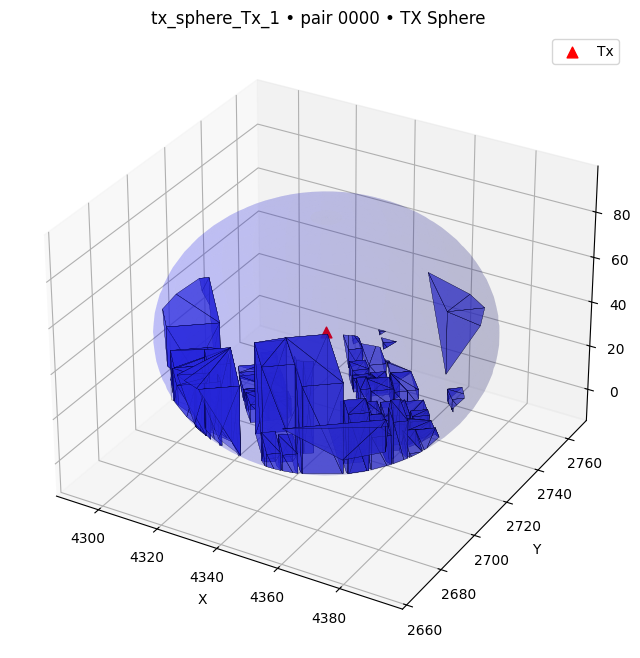

In [21]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

BASE_TX_DIR = Path("/home/mkrishne/PL_competition/extracted_regions/train/tx_sphere_Tx_1/")
PAIR_IDX_FOR_PLOT = 0

def _npz_path(base_dir: Path, pair_idx: int, tag: str) -> Path:
    return base_dir / f"pair{pair_idx:05d}_{tag}.npz"

def _load_tx(base_dir: Path, pair_idx: int):
    path = _npz_path(base_dir, pair_idx, "tx_sphere50")
    dat = np.load(path, allow_pickle=True)
    polys = [p for p in dat["polys"] if p is not None and len(p) >= 3]
    meta = {k: dat[k] for k in dat.files if k != "polys"}
    meta["Tx"] = np.array(meta["Tx"], dtype=float).reshape(-1)
    return polys, meta

def _sphere_surface(C, R, n_theta=36, n_phi=60):
    theta = np.linspace(0, np.pi, n_theta)
    phi = np.linspace(0, 2*np.pi, n_phi)
    T, P = np.meshgrid(theta, phi)
    X = C[0] + R*np.sin(T)*np.cos(P)
    Y = C[1] + R*np.sin(T)*np.sin(P)
    Z = C[2] + R*np.cos(T)
    return X, Y, Z

def plot_tx(base_dir: Path, pair_idx: int = 0):
    polys_tx, meta_tx = _load_tx(base_dir, pair_idx)
    Tx, R = meta_tx["Tx"], float(meta_tx["R"])
    Xs, Ys, Zs = _sphere_surface(Tx, R)

    # Geometry stats
    if polys_tx:
        geom_pts = np.concatenate(polys_tx, axis=0)
        print("=== TX Geometry Stats ===")
        print(f"X: min={geom_pts[:,0].min():.3f}, max={geom_pts[:,0].max():.3f}")
        print(f"Y: min={geom_pts[:,1].min():.3f}, max={geom_pts[:,1].max():.3f}")
        print(f"Z: min={geom_pts[:,2].min():.3f}, max={geom_pts[:,2].max():.3f}")
        print("=========================")
    else:
        print("No TX polygons to compute geometry stats.")

    # Plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    if polys_tx:
        ax.add_collection3d(Poly3DCollection(polys_tx, facecolor=(0.2,0.2,0.85,0.45), edgecolor='k', linewidths=0.15))
    ax.plot_surface(Xs, Ys, Zs, alpha=0.12, color='blue')
    ax.scatter(*Tx, s=60, color='red', marker='^', label='Tx')
    ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
    ax.set_title(f"{base_dir.name} • pair {pair_idx:04d} • TX Sphere")
    ax.legend()
    plt.show()


# ---- Run ----
plot_tx(BASE_TX_DIR, PAIR_IDX_FOR_PLOT)

No RX polygons to compute geometry stats.


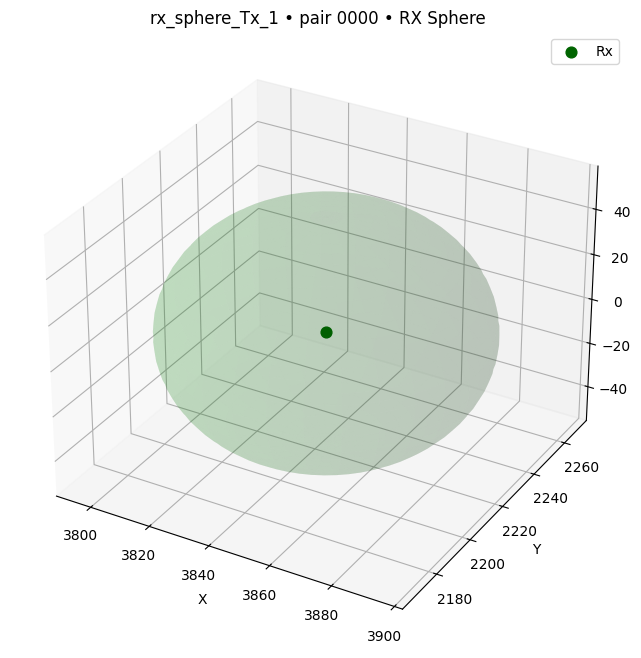

In [22]:
BASE_RX_DIR = Path("/home/mkrishne/PL_competition/extracted_regions/train/rx_sphere_Tx_1/")

def _load_rx(base_dir: Path, pair_idx: int):
    path = _npz_path(base_dir, pair_idx, "rx_sphere50")
    dat = np.load(path, allow_pickle=True)
    polys = [p for p in dat["polys"] if p is not None and len(p) >= 3]
    meta = {k: dat[k] for k in dat.files if k != "polys"}
    meta["Rx"] = np.array(meta["Rx"], dtype=float).reshape(-1)
    return polys, meta

def plot_rx(base_dir: Path, pair_idx: int = 0):
    polys_rx, meta_rx = _load_rx(base_dir, pair_idx)
    Rx, R = meta_rx["Rx"], float(meta_rx["R"])
    Xs, Ys, Zs = _sphere_surface(Rx, R)

    # Geometry stats
    if polys_rx:
        geom_pts = np.concatenate(polys_rx, axis=0)
        print("=== RX Geometry Stats ===")
        print(f"X: min={geom_pts[:,0].min():.3f}, max={geom_pts[:,0].max():.3f}")
        print(f"Y: min={geom_pts[:,1].min():.3f}, max={geom_pts[:,1].max():.3f}")
        print(f"Z: min={geom_pts[:,2].min():.3f}, max={geom_pts[:,2].max():.3f}")
        print("=========================")
    else:
        print("No RX polygons to compute geometry stats.")

    # Plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    if polys_rx:
        ax.add_collection3d(Poly3DCollection(polys_rx, facecolor=(0.2,0.8,0.2,0.45), edgecolor='k', linewidths=0.15))
    ax.plot_surface(Xs, Ys, Zs, alpha=0.12, color='green')
    ax.scatter(*Rx, s=60, color='darkgreen', marker='o', label='Rx')
    ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
    ax.set_title(f"{base_dir.name} • pair {pair_idx:04d} • RX Sphere")
    ax.legend()
    plt.show()


# ---- Run ----
plot_rx(BASE_RX_DIR, PAIR_IDX_FOR_PLOT)